In [1]:
# Loading the FER label dictionary
itol_FER = {0: 'anger', 1: 'sad', 2: 'surprise', 3: 'disgust', 4: 'happy', 5: 'neutral', 6: 'fear'}

In [2]:
import torch
device = "cuda" if torch.cuda.is_available else "cpu"
device

'cuda'

# Testing TinyVGG model with unseen dataset

dataset link: https://www.kaggle.com/datasets/tapakah68/facial-emotion-recognition

In [7]:
# Creating an instance of model
import torch
import torch.nn as nn
# Define the model
class TinyVGG(nn.Module):
    def __init__(self, conv1_channels=32, conv2_channels=64, fc1_units=128, dropout_rate=0.5, num_classes=7):
        super(TinyVGG, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, conv1_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(conv1_channels, conv2_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(conv2_channels * 16 * 16, fc1_units),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(fc1_units, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.reshape(x.size(0), -1)
        x = self.classifier(x)
        return x

# Create an instance of the model
TinyVGG_model = TinyVGG(conv1_channels=64, conv2_channels = 64, fc1_units=256, dropout_rate=0.5 ).to(device)
TinyVGG_model = TinyVGG_model.to(dtype=torch.float32)

In [9]:
!git clone https://github.com/Bhattars1/MSc-Project-Expression-Recognition-

Cloning into 'MSc-Project-Expression-Recognition-'...
remote: Enumerating objects: 84, done.
remote: Counting objects: 100% (84/84), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 84 (delta 31), reused 33 (delta 7), pack-reused 0 (from 0)
Receiving objects: 100% (84/84), 35.97 MiB | 10.46 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [10]:
TinyVGG_model_state_dict = torch.load("MSc-Project-Expression-Recognition-/TinyVGG.pth")
TinyVGG_model.load_state_dict(TinyVGG_model_state_dict)

<All keys matched successfully>

In [11]:
TinyVGG_model

TinyVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=16384, out_features=256, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=256, out_features=7, bias=True)
  )
)

Preprocessing for FER

In [17]:
# Cropping out the face using opencv model (Face detcetion)
import cv2
# Load the pre-trained Haar Cascade classifier
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
from google.colab.patches import cv2_imshow as image_show
import numpy as np

In [18]:
def image_crop(image):
    # Convert image to numpy array if it's not already
    image = np.array(image)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_image = gray_image.astype(np.uint8)

    # Perform face detection
    faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))

    # Check if at least one face is detected
    if len(faces) > 0:
        # Crop the face from the image (taking the first detected face)
        x, y, w, h = faces[0]
        cropped_face = image[y:y+h, x:x+w]
        return cropped_face

    # Return None if no face is detected
    return "No Face Detected!!!"

In [19]:
# Histogram Equalization using CLAHE and normalization
def clahe_func_normalization(image, clip_limit=2.0, grid_size=4):

    # Convert image to LAB color space
    lab_image = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)

    # Split the LAB image into its channels
    l_channel, a_channel, b_channel = cv2.split(lab_image)

    # Apply CLAHE to the L channel
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(grid_size, grid_size))
    cl_l_channel = clahe.apply(l_channel)

    # Merge the CLAHE enhanced L channel back with A and B channels
    merged_lab_image = cv2.merge((cl_l_channel, a_channel, b_channel))

    # Convert the LAB image back to RGB color space
    clahe_image = cv2.cvtColor(merged_lab_image, cv2.COLOR_LAB2RGB)

    # Normalize the final image to the 0-1 range
    final_normalized_image = clahe_image / 255.0

    return final_normalized_image

In [20]:
# resizing the image and converting to the tensor
def resize_image(image, size=64):
    # Resize the image to the specified size
    resized_image = cv2.resize(image, (size, size))
    return resized_image
def to_tensor(image):
    tensor_image = torch.tensor(image).float()
    return tensor_image

In [21]:
# Preprocessing pipeline
def preprocessing_pipeline(image):
  image = image_crop(image)
  image = clahe_func_normalization(image)
  image = resize_image(image)
  image = to_tensor(image)
  return image

In [22]:
# Checking the preprocessing function
from PIL import Image
test_image = Image.open("MSc-Project-Expression-Recognition-/sad_person.jpg")
preprocessed_image = preprocessing_pipeline(test_image)

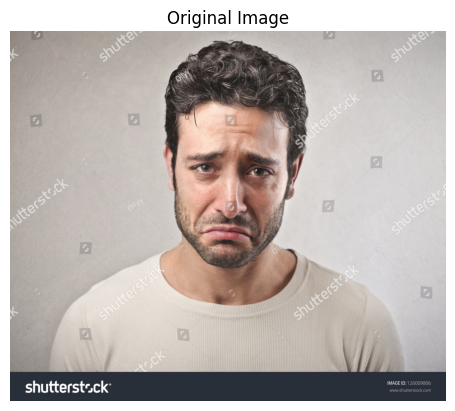

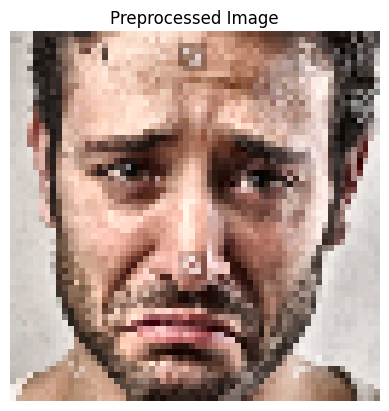

In [23]:
import matplotlib.pyplot as plt

plt.imshow(test_image)
plt.axis(False)
plt.title("Original Image")
plt.show();

plt.imshow(preprocessed_image.detach().numpy())
plt.axis(False)
plt.title("Preprocessed Image")
plt.show();

In [24]:
# Prediction
with torch.inference_mode():
    pred_logits = TinyVGG_model(preprocessed_image.permute(2,0,1).unsqueeze(dim=0).to(torch.float32).to(device))

    # Get the prediction probabilities for our samples
    pred_probs = torch.softmax(pred_logits, dim=1).argmax(dim=1)
    print(itol_FER[pred_probs.item()])

sad


In [25]:
# Prediction fuction
def predict_FER(image):
  image = preprocessing_pipeline(image)
  with torch.inference_mode():
    pred_logits = TinyVGG_model(image.permute(2,0,1).unsqueeze(dim=0).to(torch.float32).to(device))

    # Get the prediction probabilities for our samples
    pred_probs = torch.softmax(pred_logits, dim=1)
    label = itol_FER[pred_probs.argmax(dim=1).item()]
  return label, pred_probs.argmax(dim=1).item(), pred_probs

In [26]:
result = predict_FER(test_image)
print(result)

('sad', 1, tensor([[3.6766e-03, 9.9562e-01, 1.1259e-07, 1.6082e-04, 4.1621e-15, 5.4535e-04,
         4.8379e-07]], device='cuda:0'))


In [27]:
# Mounting the drive to import dataset
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [28]:
# Importing necessary libraries to import the images
from tqdm.auto import tqdm
import os


# Set up the path to the new dataset
dataset_path = '/content/drive/MyDrive/gender/new test data/data'


# Initialize lists to store images and labels
images_list = []
labels_list = []

# Initialize dictionary to store label indices and labels
label_dict = {}

# Load images from each class folder
class_idx = 0

# Iterate over class folders
for class_name in tqdm(os.listdir(dataset_path)):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):

        # Assign label index
        label_dict[class_idx] = class_name

        # Iterate over image files in class folder
        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            if os.path.isfile(img_path):

                # Load image and apply transformation
                image = Image.open(img_path)
                # Append image and label to respective lists
                images_list.append(image)
                labels_list.append(class_idx)
        class_idx += 1

# Display the number of images loaded for each class
print("Number of classes:", class_idx)
print("Total number of images:", len(images_list))

  0%|          | 0/8 [00:00<?, ?it/s]

Number of classes: 8
Total number of images: 152


In [30]:
len(images_list), len(labels_list), label_dict

(152,
 152,
 {0: 'happy',
  1: 'disgust',
  2: 'sad',
  3: 'fear',
  4: 'neutral',
  5: 'Contempt',
  6: 'surprised',
  7: 'angry'})

In [32]:
# Removing the Contempt images


# Filter images and labels to remove those with the 'Contempt' label
filtered_images_list = []
filtered_labels_list = []

for img, lbl in zip(images_list, labels_list):
    if label_dict[lbl] != 'Contempt':
        filtered_images_list.append(img)
        filtered_labels_list.append(lbl)

# Adjust the label_dict to remove 'Contempt' and re-index starting from zero
filtered_label_dict = {}
label_mapping = {}
new_index = 0

for key, value in label_dict.items():
    if value != 'Contempt':
        label_mapping[key] = new_index
        filtered_label_dict[new_index] = value
        new_index += 1

# Map the filtered labels to the new label indices
filtered_labels_list = [label_mapping[label] for label in filtered_labels_list]

# Output the results
print("Filtered Images List Length:", len(filtered_images_list))
print("Filtered Labels List Length:", len(filtered_labels_list))
print("Filtered Label Dict:", filtered_label_dict)


Filtered Images List Length: 133
Filtered Labels List Length: 133
Filtered Label Dict: {0: 'happy', 1: 'disgust', 2: 'sad', 3: 'fear', 4: 'neutral', 5: 'surprised', 6: 'angry'}


In [33]:
print(filtered_label_dict)
print(itol_FER)

{0: 'happy', 1: 'disgust', 2: 'sad', 3: 'fear', 4: 'neutral', 5: 'surprised', 6: 'angry'}
{0: 'anger', 1: 'sad', 2: 'surprise', 3: 'disgust', 4: 'happy', 5: 'neutral', 6: 'fear'}


In [35]:
# defining the accuracy function
def accuracy_fn(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  accuracy=(correct/len(y_true))*100
  return accuracy

In [40]:
# Mapping from itol_FER to filtered_label_dict
mapping = {
    0: 6,  # 'anger' -> 'angry'
    1: 2,  # 'sad' -> 'sad'
    2: 5,  # 'surprise' -> 'surprised'
    3: 1,  # 'disgust' -> 'disgust'
    4: 0,  # 'happy' -> 'happy'
    5: 4,  # 'neutral' -> 'neutral'
    6: 3   # 'fear' -> 'fear'
}

# Prediction function
def predict_FER(image):
    # Preprocess the image
    image = preprocessing_pipeline(image)

    with torch.inference_mode():
        # Get prediction logits
        pred_logits = TinyVGG_model(image.permute(2, 0, 1).unsqueeze(dim=0).to(torch.float32).to(device))

        # Get the prediction probabilities for our samples
        pred_probs = torch.softmax(pred_logits, dim=1)

        # Get the original predicted class index
        pred_class_idx = pred_probs.argmax(dim=1).item()

        # Map to the filtered label index
        mapped_class_idx = mapping[pred_class_idx]

        # Get the corresponding label from filtered_label_dict
        label = filtered_label_dict[mapped_class_idx]

    return label, mapped_class_idx, pred_probs

In [41]:
_, pred, _ = predict_FER(images_list[0])

In [42]:
pred, labels_list[0]

(2, 0)

In [43]:
FER_pred = []
for image in tqdm(filtered_images_list):
  _, pred, _ = predict_FER(image)
  FER_pred.append(pred)

  0%|          | 0/133 [00:00<?, ?it/s]

In [45]:
accuracy = accuracy_fn(torch.tensor(filtered_labels_list), torch.tensor(FER_pred))
print(f"Accuracy: {accuracy:.3f}%")

Accuracy: 51.128%


In [47]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report

# Calculate precision, recall, and F1 score
precision = precision_score(filtered_labels_list, FER_pred, average='weighted')
recall = recall_score(filtered_labels_list, FER_pred, average='weighted')
f1 = f1_score(filtered_labels_list, FER_pred, average='weighted')
accuracy = accuracy_score(filtered_labels_list, FER_pred)

# Print the metrics
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Optional: Print a detailed classification report
report = classification_report(filtered_labels_list, FER_pred, target_names=[filtered_label_dict[i] for i in range(len(filtered_label_dict))])
print("Classification Report:\n", report)


Precision: 0.5247
Recall: 0.5113
F1 Score: 0.5121
Accuracy: 0.5113
Classification Report:
               precision    recall  f1-score   support

       happy       0.70      0.74      0.72        19
     disgust       0.38      0.42      0.40        19
         sad       0.36      0.47      0.41        19
        fear       0.69      0.47      0.56        19
     neutral       0.43      0.32      0.36        19
   surprised       0.50      0.58      0.54        19
       angry       0.61      0.58      0.59        19

    accuracy                           0.51       133
   macro avg       0.52      0.51      0.51       133
weighted avg       0.52      0.51      0.51       133



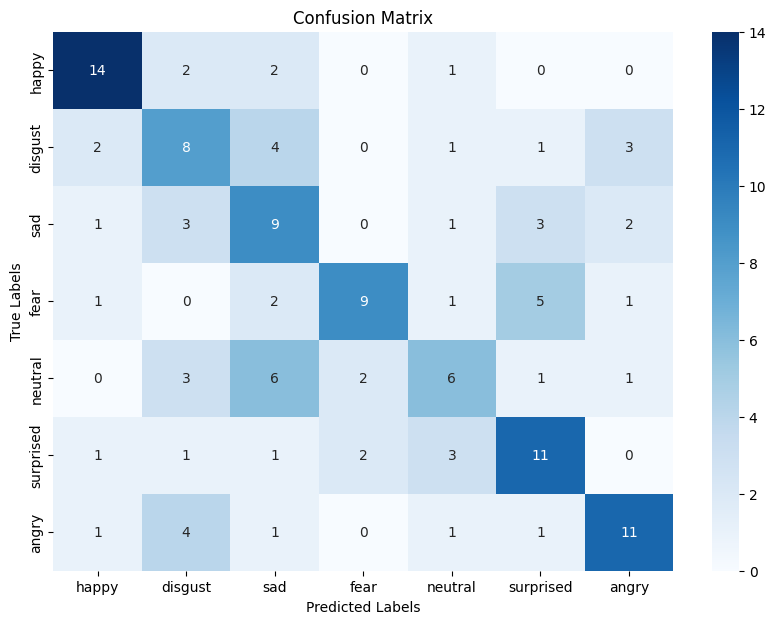

In [46]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Compute the confusion matrix
conf_matrix = confusion_matrix(filtered_labels_list, FER_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=[filtered_label_dict[i] for i in range(len(filtered_label_dict))],
            yticklabels=[filtered_label_dict[i] for i in range(len(filtered_label_dict))])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()